<a href="https://colab.research.google.com/github/Hsuan7/Deep-generative-models/blob/main/hw1_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


正在載入 MNIST 資料集...
訓練集大小: (60000, 28, 28)
測試集大小: (10000, 28, 28)

開始訓練 VAE 模型...
Epoch 1, Average loss: 165.5811
Epoch 2, Average loss: 122.1010
Epoch 3, Average loss: 114.8003
Epoch 4, Average loss: 111.7254
Epoch 5, Average loss: 110.0066
訓練完成！


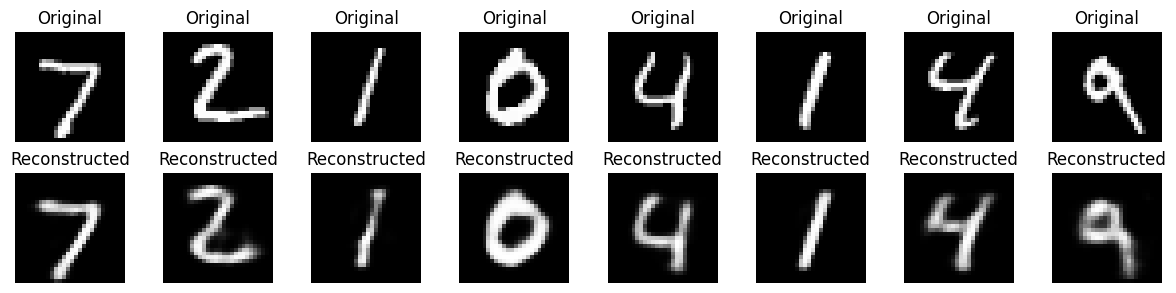

已儲存重建圖檔 reconstruction.png


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

# 解決 OpenMP 警告
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """編碼器：輸入圖像 -> 潛在空間的均值和對數方差"""
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """重參數化技巧：從正態分佈採樣"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """解碼器：潛在變數 -> 重建圖像"""
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """VAE 損失函數：重建損失 + KL 散度"""
    # 重建損失（二元交叉熵）
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL 散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def load_mnist_data(data_path='/content/drive/MyDrive/Deep-generative-models'):
    """載入 MNIST 資料集"""
    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
            data = data.reshape(-1, 28, 28).astype(np.float32) / 255.0
        return data

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # 載入訓練資料
    train_images = load_mnist_images(os.path.join(data_path, 'train-images-idx3-ubyte.gz'))
    train_labels = load_mnist_labels(os.path.join(data_path, 'train-labels-idx1-ubyte.gz'))

    # 載入測試資料
    test_images = load_mnist_images(os.path.join(data_path, 't10k-images-idx3-ubyte.gz'))
    test_labels = load_mnist_labels(os.path.join(data_path, 't10k-labels-idx1-ubyte.gz'))

    return train_images, train_labels, test_images, test_labels

def create_data_loaders(train_images, train_labels, test_images, test_labels, batch_size=128):
    """建立資料載入器"""
    train_dataset = TensorDataset(
        torch.FloatTensor(train_images),
        torch.LongTensor(train_labels)
    )
    test_dataset = TensorDataset(
        torch.FloatTensor(test_images),
        torch.LongTensor(test_labels)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_vae(model, train_loader, optimizer, epoch):
    """訓練 VAE 模型"""
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average loss: {avg_loss:.4f}')
    return avg_loss

def test_vae(model, test_loader):
    """測試 VAE 模型"""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    return test_loss

def visualize_reconstruction(model, test_loader, n_samples=8, save_path='reconstruction.png'):
    """視覺化重建結果"""
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:n_samples]
        recon_batch, _, _ = model(data)

        # 創建子圖
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 3))

        for i in range(n_samples):
            # 原始圖像
            axes[0, i].imshow(data[i].numpy().reshape(28, 28), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # 重建圖像
            axes[1, i].imshow(recon_batch[i].numpy().reshape(28, 28), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"已儲存重建圖檔 {save_path}")
        return fig

def generate_new_samples(model, n_samples=8, save_path='generated_samples.png'):
    """生成新的樣本"""
    model.eval()
    with torch.no_grad():
        # 從標準正態分佈採樣
        z = torch.randn(n_samples, 20)  # latent_dim = 20
        generated = model.decode(z)

        fig, axes = plt.subplots(1, n_samples, figsize=(15, 2))
        for i in range(n_samples):
            axes[i].imshow(generated[i].numpy().reshape(28, 28), cmap='gray')
            axes[i].set_title(f'Generated {i+1}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"生成樣本已保存至: {save_path}")

def main():
    # 設定參數
    batch_size = 128
    epochs = 5  # 改為5個epochs以匹配範例輸出
    learning_rate = 1e-3

    print("正在載入 MNIST 資料集...")
    try:
        train_images, train_labels, test_images, test_labels = load_mnist_data()
        print(f"訓練集大小: {train_images.shape}")
        print(f"測試集大小: {test_images.shape}")
    except FileNotFoundError as e:
        print(f"找不到 MNIST 資料檔案: {e}")
        print("請確保以下檔案存在於 ./mnist_data/ 資料夾中:")
        print("- train-images-idx3-ubyte.gz")
        print("- train-labels-idx1-ubyte.gz")
        print("- t10k-images-idx3-ubyte.gz")
        print("- t10k-labels-idx1-ubyte.gz")
        return

    # 建立資料載入器
    train_loader, test_loader = create_data_loaders(
        train_images, train_labels, test_images, test_labels, batch_size
    )

    # 建立模型
    model = VAE()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("\n開始訓練 VAE 模型...")

    # 訓練循環
    for epoch in range(1, epochs + 1):
        train_loss = train_vae(model, train_loader, optimizer, epoch)
        test_loss = test_vae(model, test_loader)

    print(f"訓練完成！")
    # 視覺化重建結果
    visualize_reconstruction(model, test_loader)

    # 保存模型
    torch.save(model.state_dict(), 'vae_model.pth')

if __name__ == "__main__":
    main()